# Preliminary plan for the prestressed bending tests

## Rectangular cross section 

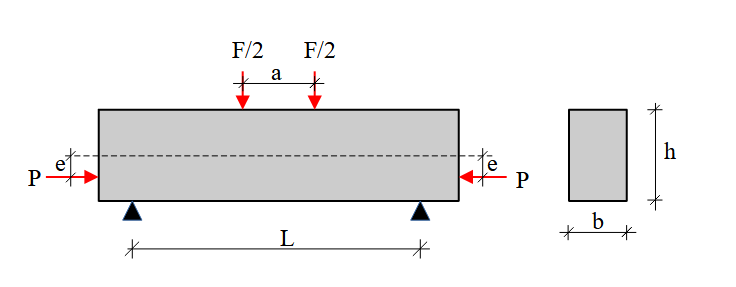

In [1]:
%matplotlib widget
import numpy as np # numerical package
import matplotlib.pyplot as plt # plotting package
import sympy as sp # computer algebra package
sp.init_printing()
import bmcs_utils.api as bu

### Beam dimensions and eccentriciy 

In [2]:
#Beam dimensions
b, h, L = sp.symbols(r'b, h, L', positive=True)

In [3]:
# Compressive strength
fc = sp.symbols(r'f_c', positive=True)

In [4]:
# Eccentricity
e = sp.symbols(r'e') 

In [5]:
# Distance between applied loading points (four point bending test)
a = sp.symbols(r'a')

Maximum eccentricity Determined from the dimensions of the used prestressing 100kN cylinder with dimameter of 70mm

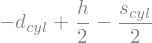

In [6]:
d_cyl = sp.symbols(r'd_cyl')
s_cyl = sp.symbols(r's_cyl')
e_max_ = h/2 - (2*d_cyl+s_cyl)/2
e_max_

In [7]:
# #Beam dimensions
# b = 100 #[mm] 
# h = 250  #[mm] 
# L = 1000 #[mm] 

# # Compressive strength
# fc = 30 #[N/mm2] 

# # Eccentricity
# e = 25 #[mm] 

# # Distance between applied loading points (four point bending test)
# a = 300 #[mm] 

# # maximum eccentricity 
# e_max = h/2 - (70+70+30)/2    # Determined from the dimensions of the used prestressing 100kN cylinder with dimameter of 70mm
# e_max 

### Resulting stresses 

#### 1. Self weight (g) 

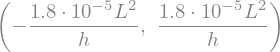

In [8]:
# Self weihgt 
q_g = b * h * 24e-6
M_g = q_g * L**2 / 8
q_g, M_g

sigma_g_top = - M_g / (b * h**2 /6)
sigma_g_bot =  M_g / (b * h**2 /6)

sigma_g_top, sigma_g_bot

#### 2. Prestressing force (pr) 

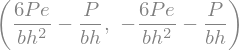

In [9]:
# Prestressing force
#P = 400e3 #[N]  # Using 4 cylinder each one 100kN
P = sp.symbols(r'P', positive=True)

M_pr = P * e

sigma_pr_top = - (P / (b * h)) + M_pr / (b * h**2 /6)
sigma_pr_bot = - (P / (b * h)) - M_pr / (b * h**2 /6)

sigma_pr_top, sigma_pr_bot

#### 3. Vertical force (f) 

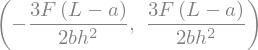

In [10]:
# Vertical force
# F = 130e3 #[N] # The machine is limited to 160kN
F = sp.symbols(r'F', positive=True)


M_f = (F/2) *(L-a)/2

sigma_f_top = - M_f / (b * h**2 /6)
sigma_f_bot = M_f / (b * h**2 /6)

sigma_f_top, sigma_f_bot

### Plotting stress profiles

In [11]:
class P4PBTExpr(bu.SymbExpr):
    # parameters
    L = L
    a = a
    e = e
    b = b
    h = h
    P = P
    F = F
    d_cyl = d_cyl
    s_cyl = s_cyl
    
    e_max_ = e_max_
    
    sigma_f_bot = sigma_f_bot
    sigma_f_top = sigma_f_top
    sigma_pr_bot = sigma_pr_bot
    sigma_pr_top = sigma_pr_top
    sigma_g_bot = sigma_g_bot
    sigma_g_top = sigma_g_top
    
    symb_model_params = ['L', 'b', 'h', 'a', 'e', 'P', 'F', 'd_cyl', 's_cyl']

    symb_expressions = [
        ('sigma_f_bot', ()),
        ('sigma_f_top', ()),
        ('sigma_pr_bot', ()),
        ('sigma_pr_top', ()),
        ('sigma_g_bot', ()),
        ('sigma_g_top', ()),
    ]

In [19]:
class P4PBT(bu.InteractiveModel, bu.InjectSymbExpr):
    symb_class = P4PBTExpr
    
    L = bu.Float(1000)
    a = bu.Float(300)
    e = bu.Float(10)
    b = bu.Float(100)
    h = bu.Float(400)
    P = bu.Float(400)
    F = bu.Float(150)
    d_cyl = bu.Float(70)
    s_cyl = bu.Float(20)
    fc = bu.Float(30)

    ipw_view = bu.View(
        bu.Item('L'),
        bu.Item('a'),
        bu.Item('e'),
        bu.Item('b'),
        bu.Item('h'),
        bu.Item('P'),
        bu.Item('F'),
        bu.Item('d_cyl'),
        bu.Item('s_cyl'),
        bu.Item('fc')
    )

    def get_sigma(self):
        
        sigma_f_bot = self.symb.get_sigma_f_bot()
        sigma_f_top = self.symb.get_sigma_f_top()
        sigma_pr_bot = self.symb.get_sigma_pr_bot()
        sigma_pr_top = self.symb.get_sigma_pr_top()
        sigma_g_bot = self.symb.get_sigma_g_bot()
        sigma_g_top = self.symb.get_sigma_g_top()

        sigma_g = np.array([ sigma_g_bot, 0, 0, sigma_g_top, sigma_g_bot])
        sigma_pr = np.array([sigma_pr_bot,  0, 0, sigma_pr_top, sigma_pr_bot])
        sigma_f = np.array([sigma_f_bot,  0, 0, sigma_f_top, sigma_f_bot])
        return sigma_g, sigma_pr, sigma_f

    def plot_stress_profiles(self, ax1, ax2, ax3, ax4):
        y = np.array([0, 0, self.h, self.h, 0])
        x_0 = np.array([0, 0, 0, 0, 0])

        sigma_g, sigma_pr, sigma_f = self.get_sigma()
        
        ax1.plot(sigma_g, y , color='black', lw=2)
        ax1.fill_between(sigma_g, y,  x_0, color='black', alpha=0.3)
        ax1.set_xlim(-self.fc/10, self.fc/100)
        ax1.set_xlabel('Stress - self weight')
        ax1.set_ylabel('Height [mm]')

        ax2.plot(sigma_pr, y , color='green', lw=2)
        ax2.fill_between(sigma_pr, y,  x_0, color='green', alpha=0.3)
        ax2.set_xlim(-self.fc, self.fc/10)
        ax2.set_xlabel('Stress - prestressing force (P)')

        ax3.plot(sigma_f, y , color='blue', lw=2)
        ax3.fill_between(sigma_f, y,  x_0, color='blue', alpha=0.3)
        ax3.set_xlim(-self.fc, self.fc)
        ax3.set_xlabel('Stress - vertical loading (F)')

        ax4.plot(sigma_g + sigma_pr + sigma_f, y , color='red', lw=2, label='loading')
        ax4.plot(sigma_g + sigma_pr, y , "--r", lw=1, label='unloading')
        ax4.fill_between(sigma_g + sigma_pr + sigma_f, y,  x_0, color='red', alpha=0.3)
        ax4.set_xlim(-self.fc, self.fc/10)
        ax4.set_xlabel('Sum of stresses')
        ax4.legend(loc=1)
        
    def plot_normalized_stress_profiles(self, ax1, ax2, ax3, ax4):
        ax1.plot(sigma_g/fc, y , color='black', lw=2)
        ax1.fill_between(sigma_g/fc, y,  x_0, color='black', alpha=0.3)
        ax1.set_xlabel('Normalized stress - self weight')
        ax1.set_xlim(-1/10, 1/100)
        ax1.set_ylabel('Height [mm]')

        ax2.plot(sigma_pr/fc, y , color='green', lw=2)
        ax2.fill_between(sigma_pr/fc, y,  x_0, color='green', alpha=0.3)
        ax2.set_xlim(-1, 1/10)
        ax2.set_xlabel('Normalized stress - prestressing force (P)')

        ax3.plot(sigma_f/fc, y , color='blue', lw=2)
        ax3.fill_between(sigma_f/fc, y,  x_0, color='blue', alpha=0.3)
        ax3.set_xlim(-1, 1)
        ax3.set_xlabel('Normalized stress - vertical loading (F)')

        ax4.plot((sigma_g + sigma_pr + sigma_f)/fc, y , color='red', lw=2, label='loading')
        ax4.plot((sigma_g + sigma_pr)/fc , y, "--r", lw=1, label='loading')
        ax4.fill_between((sigma_g + sigma_pr + sigma_f)/fc, y,  x_0, color='red', alpha=0.3)
        #ax4.fill_between((sigma_g + sigma_pr)/fc, y,  x_0, color='red', alpha=0.1)
        ax4.set_xlim(-1, 1/10)
        ax4.set_xlabel('Sum of normalized stresses')
        ax4.legend(loc=1)
    
    def subplots(self, fig):
        return fig.subplots(1,4)

    def update_plot(self, axes):
        ax1, ax2, ax3, ax4 = axes
        self.plot_stress_profiles(ax1, ax2, ax3, ax4)
        
    def report(self):
        sigma_g, sigma_pr, sigma_f = self.get_sigma()

        print("Stress ratios at top")
        print("Loading stage: Smax =", np.around(-(sigma_g + sigma_pr + sigma_f)[3]/self.fc,2))
        print("Loading stage: Smin =",  np.around(-(sigma_g + sigma_pr)[3]/self.fc, 2))
        print("Loading stage: Amplitude =", np.around(-(sigma_g + sigma_pr + sigma_f)[3]/self.fc + 
                                                      (sigma_g + sigma_pr)[3]/self.fc, 2))
        print("*****************")


        print("Stress ratios at bottom")
        print("Unloading stage: Smax =", np.around(-(sigma_g + sigma_pr)[0]/self.fc,2))
        print("Unloading stage: Smin =", np.around(-(sigma_g + sigma_pr + sigma_f)[0]/self.fc, 2))
        print("Loading stage: Amplitude =", np.around(+(sigma_g + sigma_pr + sigma_f)[0]/self.fc - 
                                                      (sigma_g + sigma_pr)[0]/self.fc, 2))


In [20]:
p4pbt = P4PBT()

In [21]:
p4pbt.interact()

### Normalized stress profiles ($\sigma$ / fc)

In [22]:
p4pbt.report()

Stress ratios at top
Loading stage: Smax = 0.0
Loading stage: Smin = 0.0
Loading stage: Amplitude = 0.0
*****************
Stress ratios at bottom
Unloading stage: Smax = -0.0
Unloading stage: Smin = -0.0
Loading stage: Amplitude = 0.0


### Summary of some requirements
1. After applying the prestressing force:
 - stress at the top < 0 (no tension)
 - stress at the bottom < fc 
 ----
2. The sum of stresses:
 - no tension at bottom
 - stress at the top < fc
 - The differnce of the streess at top during loading and unloading should be large enough to get fatigue failure